<center>

# AIIP Project: Segment Anything Model Fine-tuninig on Electron Microscopic Images of Cells' Mitochondrias

## By:
## Amr MOHAMED
## Anh Thu DOAN
## Gwendal AUPHAN
#### CY Tech, ING-3, Aritificial Intelligence Group 2
#### 05/11/2023

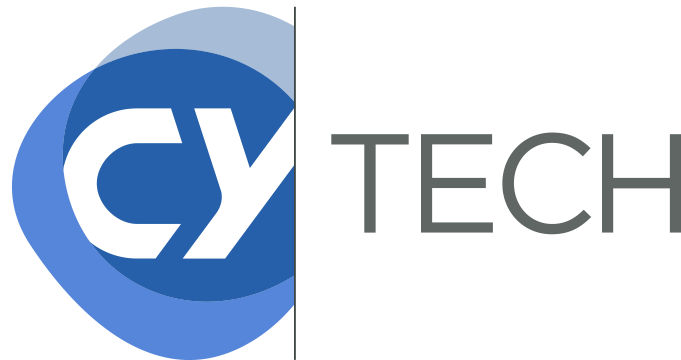
</center>

<br>

SAM is an image segmentation model developed by Meta AI. It was trained over 11 billion segmentation masks from millions of images. It is designed to take human prompts, in the form of points, bounding boxes or even a text prompt  describing what should be segmented.

It represents a significant breakthrough in the field of computer vision. Developed as part of the Segment Anything (SA) project, SAM is designed to excel at image segmentation, a fundamental task with applications across various domains. This report delves into the implementation and fine-tuning of SAM for the specific challenge of segmenting **mitochondrias in microscopic cell images**, a critical task in medical and biological research.

In this report, we go through the full process of a computer vision project to fine tune the SAM model, starting by inspecting the statical features of the images (shape, number of channels, number of images/masks etcc) , passing through the preprocessing of the images, and preparing them for fine tuning the model, fine tuning the model, and finally, evaluating the fine tuned model on the test set, and inspecting the differences between the performance of the tuned and untuned models on the test set.
<p>

**What are the key features of SAM?**
<br>

* **Zero-shot generalization:** SAM readily accepts diverse inputs, including points, bounding boxes, and textual descriptions.

* **Flexible prompting:** SAM can be prompted with a variety of input, including points, boxes, and text descriptions.

* **Real-time mask computation:** SAM swiftly generates object masks in real-time, catering to applications requiring rapid segmentation, such as autonomous driving and robotics.

* **Ambiguity awareness:** SAM's keen sensitivity to object ambiguities in images empowers it to produce masks even in cases of partial occlusion or object overlap.

<p>

**How does SAM work?**

<br>
SAM initiates the process by encoding the image into a high-dimensional vector representation. Simultaneously, it encodes the prompt into a distinct vector representation. These two vector representations are then combined and directed to a mask decoder, responsible for generating a mask corresponding to the specified object in the prompt.
<p>
The image encoder takes the form of a Vision Transformer (ViT-H) model, a substantial language model that has undergone pre-training on an extensive image dataset. The prompt encoder, on the other hand, adopts a straightforward text encoding approach, translating the input prompt into a vector representation. Lastly, the mask decoder, a lightweight transformer model, fulfills the task of predicting the object mask based on the combined image and prompt embeddings.
<p>


# Section 0: Necessary Packages Installation and Importing

In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

from datasets import Dataset
from PIL import Image
from transformers import SamProcessor
from torch.utils.data import DataLoader
from transformers import SamModel
from torch.optim import Adam
import monai
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from transformers import SamModel, SamConfig, SamProcessor
import torch
import numpy as np
import random
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

# Section 1: Images Reading and Inspection

In this project, we use **EPFL's Electron Microscopy Dataset** that is represented by **330 cellular grayscale images** taken under an electron microscope , with 330 respective annotations (masks) also encoded as images, where the data is already split into **165 image for training** and **165 for testing**. Each image is of size **768x1024** (1 channel only per image/mask). Each pile of images is encoded as tiff stack (.tif), therefor, we unstack them using the .imread function from the tifffile package


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Load tiff stack images and masks
train_images = tifffile.imread("./drive/My Drive/AIIP Project Datasets/mitochondria/training.tif")
train_masks = tifffile.imread("./drive/My Drive/AIIP Project Datasets/mitochondria/training_groundtruth.tif")

#Apply a trained model on large image
test_images = tifffile.imread("./drive/My Drive/AIIP Project Datasets/mitochondria/testing.tif")
test_masks = tifffile.imread("./drive/My Drive/AIIP Project Datasets/mitochondria/testing_groundtruth.tif")

In [12]:
print('Number of training images: ', len(train_images))
print('Image size: ', train_images[0].shape,'\n')
print('Number of testing images: ', len(test_images))
print('Image size: ', test_images[0].shape)

Number of training images:  165
Image size:  (768, 1024) 

Number of testing images:  165
Image size:  (768, 1024)


# Section 2: Images Preprocessing

In [13]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In the cell above, we defined the patch_size, so it is 256 pixels in both the X and Y directions, and the step is also 256, allowing no over lapping between the patches. For example, since the image has the size 768x1024, and 768/256 = 3, and 1024/2565 = 4, it means the 1 image will result in generating 12 different subimages, which will also be of benefit for the model to be trained on a wider set of images, i.e: we also utilized it as a form of **Image Augmentation**

In [14]:
def patch_images(large_images,large_masks):
  all_img_patches = []
  for img in range(large_images.shape[0]):
      large_image = large_images[img]
      patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

      for i in range(patches_img.shape[0]):
          for j in range(patches_img.shape[1]):

              single_patch_img = patches_img[i,j,:,:]
              all_img_patches.append(single_patch_img)

  images = np.array(all_img_patches)
  #Let us do the same for masks
  all_mask_patches = []
  for img in range(large_masks.shape[0]):
      large_mask = large_masks[img]
      patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

      for i in range(patches_mask.shape[0]):
          for j in range(patches_mask.shape[1]):

              single_patch_mask = patches_mask[i,j,:,:]
              single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
              all_mask_patches.append(single_patch_mask)

  masks = np.array(all_mask_patches)

  return images,masks
patched_train_images , patched_train_masks = patch_images(train_images, train_masks) # patch the training set
patched_test_images , patched_test_masks = patch_images(test_images, test_masks) # patch the testing set

In [15]:
print(patched_train_images.shape)
print(patched_train_masks.shape)
print(patched_test_images.shape)
print(patched_test_masks.shape)

(1980, 256, 256)
(1980, 256, 256)
(1980, 256, 256)
(1980, 256, 256)


From the cell above, we can see as we mentioned above, patching, by simple calulations should result is 12 times the size of the original dataset, which we can see from the code above. Now, since we divided each image into 12 sub images, and some images, can have few number of mitochondrias, so patching will result in some images which are empty, i.e have no mitochondrias, therefor, we further check, if the mask doesn't have any mitochondrias (maximum pixel value is not white/zero value), we remove the tuple of image-mask form the set.

In [16]:
def remove_emptys(images,masks):
  # Create a list to store the indices of non-empty masks
  valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
  # Filter the image and mask arrays to keep only the non-empty pairs
  return images[valid_indices], masks[valid_indices]

filtered_train_images, filtered_train_masks = remove_emptys(patched_train_images,patched_train_masks)
print("Filtered train images shape:", filtered_train_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Filtered train masks shape:", filtered_train_masks.shape,'\n')

filtered_test_images, filtered_test_masks = remove_emptys(patched_test_images,patched_test_masks)
print("Filtered test images shape:", filtered_test_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Filtered test masks shape:", filtered_test_masks.shape)

Filtered train images shape: (1642, 256, 256)
Filtered train masks shape: (1642, 256, 256) 

Filtered test images shape: (1725, 256, 256)
Filtered test masks shape: (1725, 256, 256)


From the cell above, we can see that 338 images/masks were removed from 338 the training set, since they were empty of mitochondrias. We furtger create dataset object for each of the training and testing sets to be easier to work with.

In [17]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
train_dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_train_images],
    "label": [Image.fromarray(mask) for mask in filtered_train_masks],
}

# Create the dataset using the datasets.Dataset class
train_dataset = Dataset.from_dict(train_dataset_dict)
# Convert the NumPy arrays to Pillow images and store them in a dictionary
test_dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_test_images],
    "label": [Image.fromarray(mask) for mask in filtered_test_masks],
}
# Create the dataset using the datasets.Dataset class
test_dataset = Dataset.from_dict(test_dataset_dict)

We further inspect the images and masks to make sure they were aligned correctly.

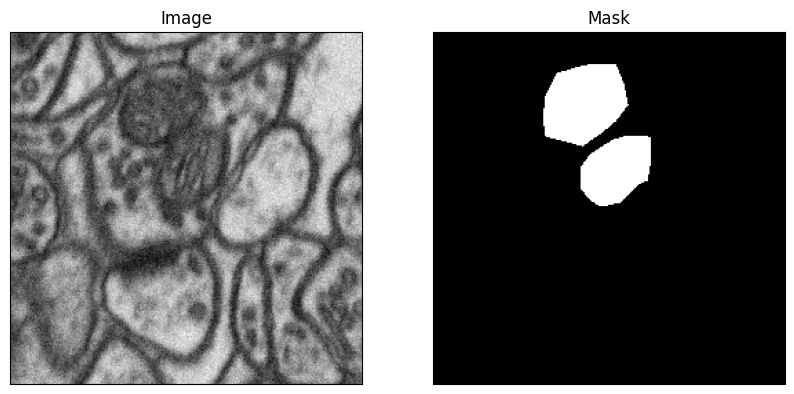

In [18]:
img_num = random.randint(0, filtered_train_images.shape[0]-1)
example_image = train_dataset[img_num]["image"]
example_mask = train_dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

As mentioned in the introduction of the notebook, the SAM model takes as an argument a prompt, which can be a point, a bounding box, or even a text about/around the orject to be segmented. Its important to note that the text prompt option has not been published for the open source by Meta AI. We here further implement a function that returns the coordinates of the bounding box around the object to be segmented, just using the difference in the masks pixels values.

In [19]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]
  return bbox

Moving forward, we here create a class called SAMDataset, that takes as a parameters the dataset that was created previously, and the pre-trained Vision Transformer (ViT) that servers as the image encoder of the model, then creates the prompt (bounding box), and therefore outputs the inputs of the model, that are the image, the mask, and the prompt.

In [20]:
from torch.utils.data import Dataset
class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

We here load the  pre-trained Vision Transformer (ViT) from facebook.

In [21]:
# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

Further, we create the sam dataset as mentioned above.

In [22]:
# Create an instance of the SAMDataset
train_dataset_sam = SAMDataset(dataset=train_dataset, processor=processor)

In [23]:
example = train_dataset_sam[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


From the cell above, we see that now, the dataset contains a pixel_values object of 1024x1024x3, which are the image, the mask, and the prompts, each casted to 1024x1024 matrix, as this is the input sizes for the same model, the input boxes is 1,4 since it is 1-d array contating the information about the minimum and maximum values of the x and y coordinates of the bounding box, and finally the ground truth is the orignial patched mask

In [25]:
# Create a DataLoader instance for the training dataset
train_dataloader = DataLoader(train_dataset_sam, batch_size=2, shuffle=True, drop_last=False)

In [26]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [27]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

# Section 3: Fine tuning SAM

Further, we initialize a SamModel object, using the pretrained weights directly from facebook, and again, that was trained using the ViT image encoder. It **very important** to note that we further **fine tune only the Mask Decoder**, and therefore, we **freeze the weights of the ViT image encode, and the Prompt encoder**, so that we don't lose any of the weights or information previously learnt by the model, and we tune only the part that combines together both the information of the prompt and the image, which has to be relevant for the mitochondria dataset.

In [28]:
# Load the model
model = SamModel.from_pretrained("facebook/sam-vit-base")
# make sure we only compute gradients for mask decoder (freezing the image encoder and the prompt encoder )
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

Moreoover, we define the optimizer and the loss functions to be used. For the optimizer we use the adaptive optimizer Adam on the parameters of the mask decoder, learning rate equal to 1e-5 and zero weight decay, while for the loss function, we use a custom loss function from the monai package, which is a combination of the Dice loss and Cross Entropy Loss, where it computes both Dice loss and Cross Entropy Loss, and return the weighted sum of these two losses. The benefit of doing this is that the Cross-Entropy Loss makes sure the model is good at figuring out what's in each pixel, which is crucial for separating objects from the background. It also handles situations where there are many more background pixels than object pixels. This combined loss helps the model work better in terms of pixel-wise accuracy and getting the objects right. It's like having a balance between being good at classifying pixels and drawing object boundaries. This approach makes the model stronger, less likely to make mistakes, and able to handle different data more effectively during training.







In [29]:
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

Finally, we reach the fine tuning stage, where we train the model for 5 loops, where it showed a neglible reduction in the loss funtion after the fifth training epoch. Fine tuning sam requires a lot of computation resources, where training it using the T4 GPU takes approximatly 14 mins/epoch, while training of the V100 GPU takes approximately 5 mins/epoch.

In [26]:
# #Training loop
# num_epochs = 5

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

# model.train()
# for epoch in range(num_epochs):
#     epoch_losses = []
#     for batch in tqdm(train_dataloader):
#       # forward pass
#       outputs = model(pixel_values=batch["pixel_values"].to(device),
#                       input_boxes=batch["input_boxes"].to(device),
#                       multimask_output=False)

#       # compute loss
#       predicted_masks = outputs.pred_masks.squeeze(1)
#       ground_truth_masks = batch["ground_truth_mask"].float().to(device)
#       loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

#       # backward pass (compute gradients of parameters w.r.t. loss)
#       optimizer.zero_grad()
#       loss.backward()

#       # optimize
#       optimizer.step()
#       epoch_losses.append(loss.item())

#     print(f'EPOCH: {epoch}')
#     print(f'Mean loss: {mean(epoch_losses)}')

We further save the model learnt weights in order to save the training time for the future uses/testing of the fine tuned model.

In [1]:
# # Save the model's state dictionary to a file
# torch.save(model.state_dict(), "./drive/My Drive/AIIP Project Datasets/mitochondria/mito_model_checkpoint_5epochs_final_final.pth")

# Section 4: Model Evaluation

To start the model evaluation phase, and corresponding to the motivation of the SAM model fine tuning, SAM model already performs well on the general tasks, but not on such scientific tasks, and from there came the motivation to fine tune it, to achieve the best out of the model. Therefore, we load the model, with the pretrianed weights, without any modifications, and we compare it with the tuned model, to see how much of advancement did we achieve by fine tuning the SAM model.

In [30]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
five_epochs_model = SamModel(config=model_config)
model_untuned = SamModel.from_pretrained("facebook/sam-vit-base")
#Update the model by loading the weights from saved file.
five_epochs_model.load_state_dict(torch.load("./drive/My Drive/AIIP Project Datasets/mitochondria/mito_model_checkpoint_5epochs_final_final.pth"))

<All keys matched successfully>

We make sure we utilize the GPU for processing both models

In [31]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
model_untuned.to(device)
five_epochs_model.to(device)
device

'cuda'

We further create a function to utilize the model to predict the segmentation mask given a test image, these outputs are sigmoid output [0,1], and we use the threshold of >0.5 to mark a pixel as a part of the mitochondria.

In [32]:
def get_predicted_mask(model,inputs):
  model.eval()
  # forward pass
  with torch.no_grad():
      outputs = model(**inputs, multimask_output=False)

  # apply sigmoid
  medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
  medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
  return medsam_seg

Furthermore, we define two scoring functions to evaluate the models performance on the test set:

*  ## Dice coefficient :
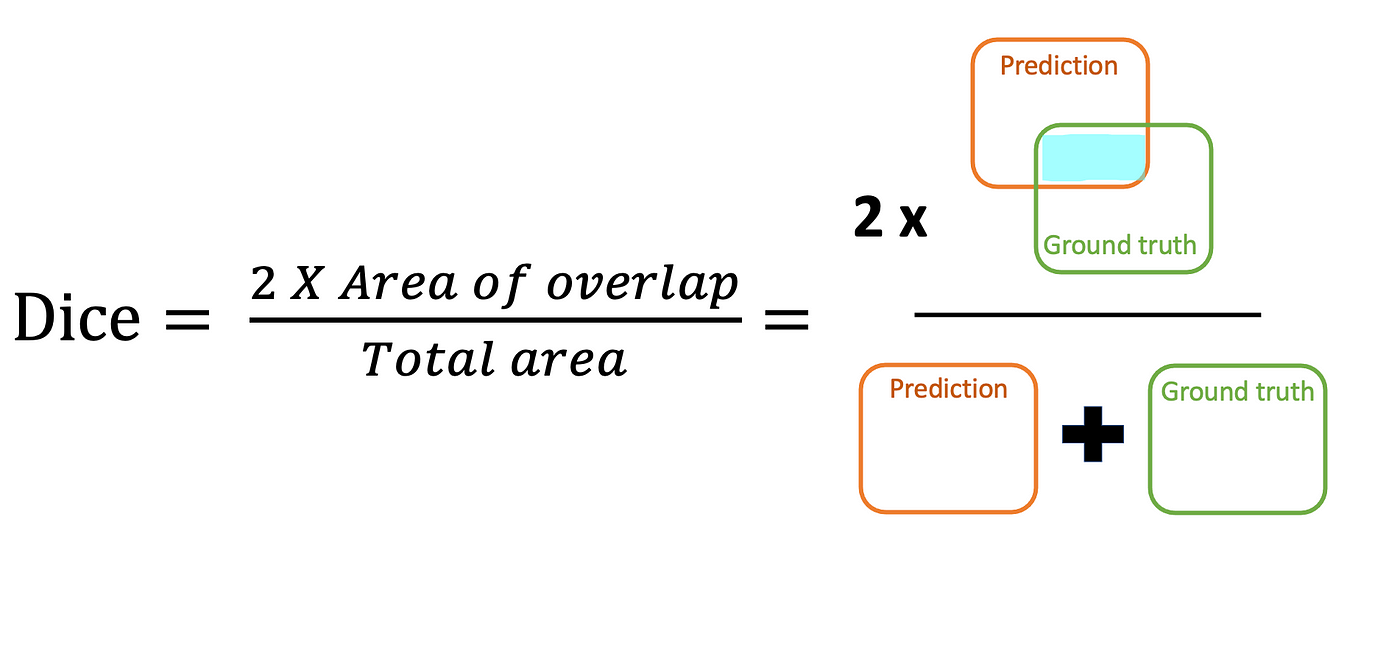

* ## IoU (Intersect over Union) coefficient:
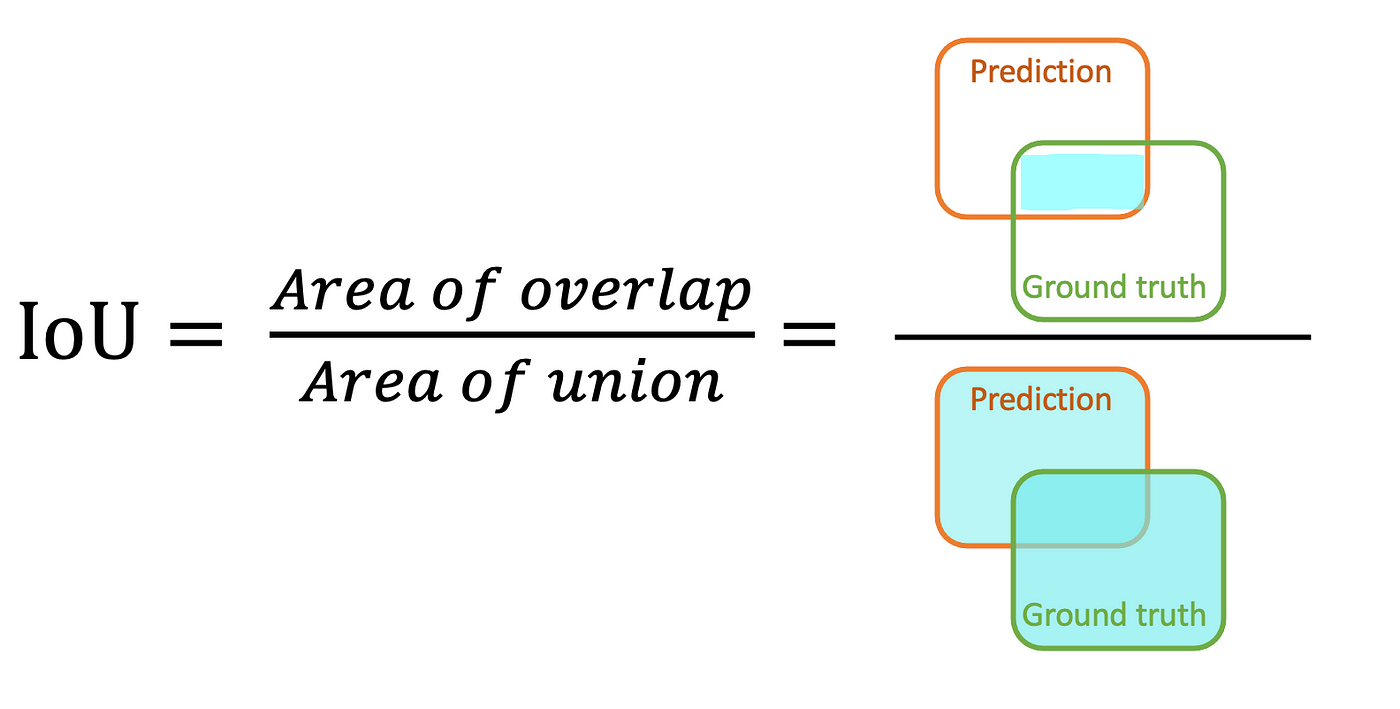


In [1]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

# Tuned and untuned models evaluation and performance differences inspection

We further define a fubnction to plot the images, the ground truth mask, and the other two predicted masks

In [34]:
# let's take a random training example
# idx = random.randint(0, filtered_test_images.shape[0]-1)
def visual_comparison(idx):
  # load image
  test_image = test_dataset[idx]["image"]
  # get box prompt based on ground truth segmentation map
  ground_truth_mask = np.array(test_dataset[idx]["label"])
  prompt = get_bounding_box(ground_truth_mask)
  # prepare image + box prompt for the model
  inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
  # Move the input tensor to the GPU if it's not already there
  inputs = {k: v.to(device) for k, v in inputs.items()}

  five_epochs_model_pred_mask = get_predicted_mask(five_epochs_model,inputs)
  untrained_model_pred_mask = get_predicted_mask(model_untuned,inputs)

  tuned_dice,tuned_iou = np.round(dice_coef(ground_truth_mask , five_epochs_model_pred_mask),2),np.round(iou(ground_truth_mask , np.round(five_epochs_model_pred_mask)),2)
  untuned_dice,untuned_iou = np.round(dice_coef(ground_truth_mask , untrained_model_pred_mask),2),np.round(iou(ground_truth_mask , np.round(untrained_model_pred_mask)),2)


  fig, axes = plt.subplots(1, 4, figsize=(15, 5))

  # Plot the first image on the left
  axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
  axes[0].set_title("Image")

  # Plot the second image on the right
  axes[1].imshow( ground_truth_mask, cmap='gray')  # Assuming the second image is grayscale
  axes[1].set_title("Ground Truth Mask")

  # Plot the second image on the right
  axes[2].imshow(untrained_model_pred_mask, cmap='gray')  # Assuming the second image is grayscale
  axes[2].set_title(f"Untuned SAM Predicted Mask \n(Dice score : {untuned_dice} , IoU score: {untuned_iou})")

  # Plot the second image on the right
  axes[3].imshow(five_epochs_model_pred_mask, cmap='gray')  # Assuming the second image is grayscale
  axes[3].set_title(f"Tuned SAM Predicted Mask \n(Dice score : {tuned_dice} , IoU score: {tuned_iou})")

  # Hide axis ticks and labels
  for ax in axes:
      ax.set_axis_off()

  # Display the images side by side
  plt.show()
  return ground_truth_mask , five_epochs_model_pred_mask , untrained_model_pred_mask

Finally, we define *evaluate* function which loops over the test set and evaluates each image by calculating each of the dice and IoU score between the predicted and ground truth masks

In [35]:
def evaluate(model):
  scores = []
  for idx in tqdm(range(len(test_dataset))):
    test_image = test_dataset[idx]["image"]
    ground_truth_mask = np.array(test_dataset[idx]["label"])
    prompt = get_bounding_box(ground_truth_mask)
    # prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}
    pred = get_predicted_mask(model,inputs)
    scores.append([dice_coef(ground_truth_mask, pred), iou(ground_truth_mask, pred)])
  return scores

In [112]:
untuned_model_scores = evaluate(model_untuned)

100%|██████████| 1725/1725 [13:30<00:00,  2.13it/s]


In [113]:
untuned_mean_dice, untuned_mean_iou = np.mean(untuned_model_scores,axis=0)
print('Untuned model mean Dice score : ', round(untuned_mean_dice,3))
print('Untuned model mean IoU score : ', round(untuned_mean_iou,3))

Untuned model mean Dice score :  0.571
Untuned model mean IoU score :  0.47


In [114]:
tuned_model_scores = evaluate(five_epochs_model)

100%|██████████| 1725/1725 [13:32<00:00,  2.12it/s]


In [115]:
tuned_mean_dice, tuned_mean_iou = np.mean(tuned_model_scores,axis=0)
print('Tuned model mean Dice score : ', round(tuned_mean_dice,3))
print('Tuned model mean IoU score : ', round(tuned_mean_iou,3))

Tuned model mean Dice score :  0.855
Tuned model mean IoU score :  0.764


From the two cells above, we can clearly see a huge advancement in the model performance after the fine tuning where the dice score increased by approximately 0.3 from the untuned to the tuned model, with a total of approximately 0.85, meaning that on average, approximately 85% of the pixels in the test masks overlap with the respective predicted masks by the fine tuned SAM, while the IoU score passed from 0.47 on the untuned model to 0.764 indicating  that approximately 76.4% of the region where the two masks (the actual and the predicted) overlap corresponds to the same object or segmentation area. <br>
Noticing this huge advancement from the base model (untuned) to the tuned model, we here inspect some examples of the test set, to infer and have a better intepretation of the results.

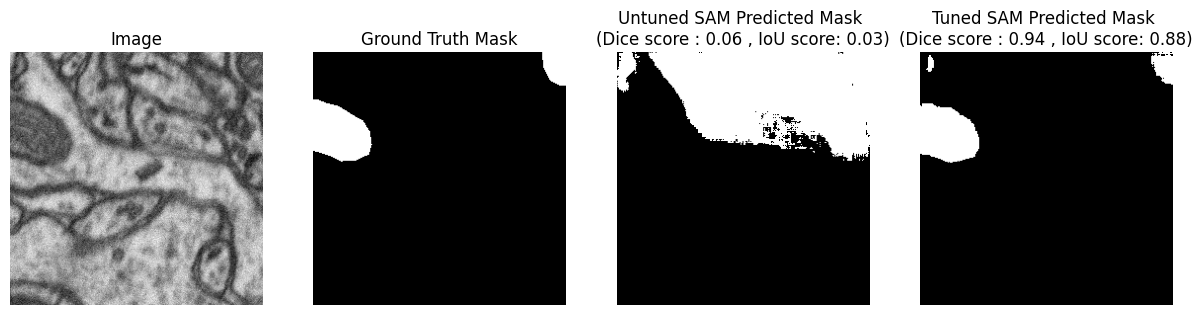

In [51]:
idx = random.randint(0, filtered_test_images.shape[0]-1)
gt , tuned_mask, untuned_mask = visual_comparison(idx)

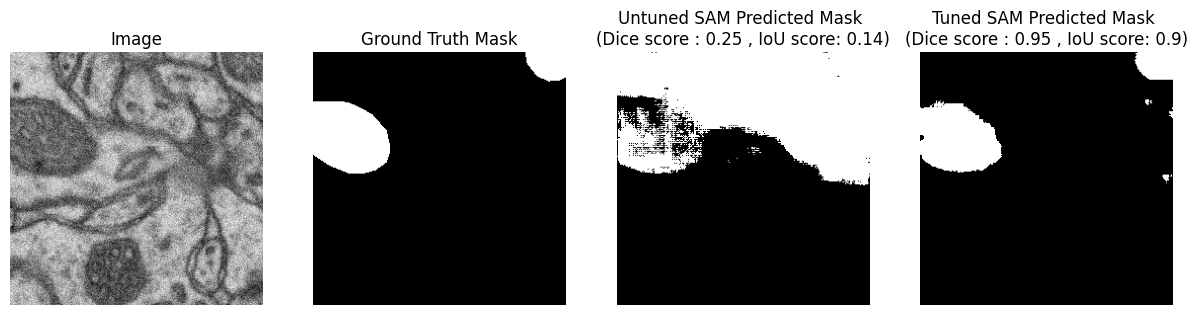

In [53]:
idx = random.randint(0, filtered_test_images.shape[0]-1)
gt , tuned_mask, untuned_mask = visual_comparison(idx)

By inspecting the results of the model above after and before fine tuning, we can still visually see the huge impact on fine tuning the mask decoder weights of SAM on the mitochondria microscopic images, and the difference in performance is approximately the double according to the dice and IoU scoring functions as well, when tested on the full testing set.<br>
By these findings, we can now condlude that SAM is a very ^power full state-of-art model, that can work averagely on scientific tasks, and in specific cellular images segmentation, however, when fine tuned on a dataset of images for the specific task, it can be much more powerfull, exceeding most of the recent state-of-art segmentation models.